In [1]:
#import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from collections import defaultdict
import pandas as pd

In [2]:
np.random.seed(7)

In [3]:
def get_triplets(lst):
    """
    '1234' -> ['123','234']
    """
    res = []
    for i in range(len(lst) - 2):
        res.append(lst[i]+lst[i + 1]+lst[i + 2])
    return res


def get_dinucleotides(lst):
    """
    '123' -> ['12', '23']
    """
    res = []
    for i in range(len(lst) - 1):
        res.append(lst[i]+lst[i + 1])
    return res

In [4]:
#True: Last bases of Alus
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/Alu_All_50_bs_2.txt','r') as f:
    dt = np.unique(list(map(lambda x: x.strip(),f.readlines())))

In [5]:
#False: Random genome sequences
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/random_nt_seq.txt','r') as f:
    df = np.unique(list(map(lambda x: x.strip(),f.readlines())))


In [6]:
len(dt), len(df)

(5017, 19999)

In [7]:
# Balancing alternative
# d = df if len(df) > len(dt) else dt
p = len(df)/len(dt); m = min(p,1/p)
np.random.seed(7)
df = np.random.choice(df,round(len(df)*m), replace=False)
dt = np.random.choice(dt, len(dt), replace=False)

In [8]:
len(dt), len(df)

(5017, 5017)

In [9]:
alph = ['A','C','G','T']
alph_dict = {'A':1,'C':2,'G':3,'T':4}
pairs = [''.join(i) for i in product(alph, repeat=2)]
triplets = [''.join(i) for i in product(alph, repeat=3)]

In [10]:
x_t, y_t = [], []
for line in dt:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_t.append(1)
    x_t.append(row)

In [11]:
x_f, y_f = [], []
for line in df:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_f.append(0)
    x_f.append(row)

In [12]:
x_all = pd.DataFrame(x_t + x_f).fillna(0)
y_all = np.array(y_t + y_f)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, random_state=7, test_size=0.3)

In [14]:
np.mean(y_train), np.mean(y_test)

(0.49935924818453653, 0.5014945200929923)

In [15]:
#tr = xgboost.XGBClassifier(max_depth=5,n_estimators=100,random_state=7)
#params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [16]:
tr = RandomForestClassifier(max_depth=5,n_estimators=100,random_state=7)
params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [17]:
gr = GridSearchCV(tr,param_grid=params,n_jobs=6,cv=5,)

In [18]:
gr.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [5, 8, 11, 15, 20], 'n_estimators': [100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
gr.best_score_, gr.best_params_

(0.9964402676918696, {'max_depth': 11, 'n_estimators': 1000})

In [20]:
y_pred = gr.best_estimator_.predict(x_test)

In [21]:
roc_auc_score(y_test,y_pred)

0.99767616291126

In [22]:
fpr, tpr, _ = roc_curve(y_test,gr.best_estimator_.predict_proba(x_test)[:,1])

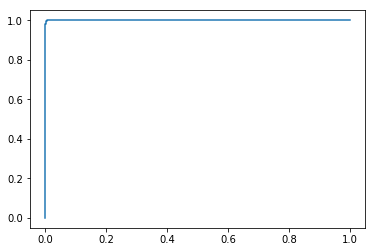

In [23]:
plt.plot(fpr,tpr);

In [24]:
auc(fpr,tpr)

0.9999466139571411

In [25]:
accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred)

(0.9976751909664563, 0.9980119284294234, 0.9973509933774835)

In [47]:
top_features = list(sorted(zip(x_train.columns, gr.best_estimator_.feature_importances_), key=lambda x: x[1], reverse=True))
top_features

[('CTC', 0.10468749611225996),
 ('TT', 0.0901874456246408),
 ('ACT', 0.06820996622505929),
 ('TA', 0.06809115315677902),
 ('GCG', 0.05142353639966344),
 ('CG', 0.03552223834689339),
 ('TTT', 0.03535384500669685),
 ('AGA', 0.03459106538604727),
 ('CGA', 0.029378460572030408),
 ('TTA', 0.027692364711967673),
 ('CTT', 0.026724835297351722),
 ('P38', 0.026101018497244135),
 ('GC', 0.02342582561598461),
 ('TC', 0.02067520695395388),
 ('GAC', 0.018794150409938433),
 ('AT', 0.017366737661729942),
 ('P40', 0.017164811253708334),
 ('P48', 0.015350248225857852),
 ('GGG', 0.014946909573650071),
 ('P32', 0.01330949916436087),
 ('CCA', 0.012971609249349982),
 ('GCC', 0.012950911109069532),
 ('TTC', 0.011496762479021731),
 ('TAA', 0.009959334080444653),
 ('CAC', 0.009349885469734706),
 ('AA', 0.00864586626076358),
 ('AAA', 0.008532950473523898),
 ('TCC', 0.007793346882734612),
 ('AGG', 0.007312786204998085),
 ('P34', 0.007234805664352757),
 ('TAT', 0.007025253768197661),
 ('P46', 0.00687585118999548

In [27]:
len(gr.best_estimator_.feature_importances_)

130

In [28]:
len(x_train.columns)

130

In [29]:
gr.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [34]:
pd.DataFrame(
    columns=pairs, data=[
        x_all[y_all==1][pairs].mean(),
        x_all[y_all==0][pairs].mean(),
        x_all[y_all==1][pairs].std(),
        x_all[y_all==0][pairs].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(4)

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
Mean t,2.4359,3.9113,4.6275,1.3349,4.7206,3.9384,2.6073,4.8051,4.2597,4.5266,2.3243,1.4927,0.2492,4.4443,2.9079,0.4144
Mean f,4.6879,2.4246,3.5166,3.7534,3.5270,2.5878,0.4495,3.4776,2.9241,2.0734,2.5996,2.4770,3.2621,2.9575,3.5023,4.7797
Std t,4.8658,1.0851,0.9679,0.9102,1.2823,1.2006,1.4550,1.0033,1.0555,1.2711,0.8393,0.9427,0.6344,0.8141,1.1641,0.6445
Std f,3.3512,1.6205,2.0335,2.3221,1.8726,2.5217,0.9020,2.0437,1.8870,1.6370,2.5552,1.6673,2.3264,1.9451,1.8757,3.4293


In [57]:
pd.DataFrame(
    columns=triplets, data=[
        x_all[y_all==1][triplets].mean(),
        x_all[y_all==0][triplets].mean(),
        x_all[y_all==1][triplets].std(),
        x_all[y_all==0][triplets].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(1)

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
Mean t,1.5,0.4,0.5,0.1,1.1,0.3,0.1,2.5,2.5,1.6,...,0.4,1.2,0.4,1.2,1.0,0.3,0.0,0.1,0.3,0.0
Mean f,1.7,0.7,1.0,1.2,1.0,0.5,0.1,0.8,1.1,0.7,...,0.1,1.1,0.9,0.7,0.8,1.0,1.0,1.0,0.9,1.8
Std t,4.2,0.7,0.7,0.6,0.6,0.5,0.3,0.7,0.8,0.7,...,0.5,0.5,0.6,0.7,0.3,0.5,0.1,0.3,0.5,0.2
Std f,2.1,0.9,1.0,1.2,1.2,0.8,0.3,0.9,1.2,0.8,...,0.3,1.2,0.9,0.9,0.9,1.2,1.1,1.1,0.9,2.1


In [61]:
pd.DataFrame(
    columns=x_all.columns, data=[
        x_all[y_all==1].mean(),
        x_all[y_all==0].mean(),
        x_all[y_all==1].std(),
        x_all[y_all==0].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(2)[list(filter(bool, map(lambda x: x[0] in pairs+triplets and x[0] or None, top_features)))[:20]]

,CTC,TT,ACT,TA,GCG,CG,TTT,AGA,CGA,TTA,CTT,GC,TC,GAC,AT,GGG,CCA,GCC,TTC,TAA
Mean t,2.68,0.41,2.45,0.25,1.32,2.61,0.02,2.54,1.06,0.01,0.05,4.53,4.44,1.60,1.33,1.03,1.97,1.70,0.09,0.08
Mean f,0.80,4.78,0.77,3.26,0.10,0.45,1.76,1.08,0.10,1.04,1.03,2.07,2.96,0.47,3.75,0.70,0.84,0.55,1.01,1.03
Std t,0.61,0.64,0.73,0.63,0.91,1.45,0.16,0.83,0.80,0.12,0.22,1.27,0.81,0.65,0.91,0.51,0.79,0.69,0.30,0.50
Std f,1.12,3.43,0.85,2.33,0.41,0.90,2.12,1.18,0.34,1.13,1.06,1.64,1.95,0.70,2.32,1.32,0.97,0.82,1.06,1.15
